In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def binormal(x,rho):
    x1,x2 = x
    z = x1*x1-2*rho*x1*x2+x2*x2
    return np.exp( -z/(2*(1-rho)) )
# end def

def metropolis_bivariate_std_normal(rho,nsample,sig=0.5):
    sample0 = (0,0)
    samples = np.zeros([nsample,2])
    samples[0,:] = sample0
    naccept = 0
    for isample in range(1,nsample):
        proposal = sig*np.random.randn(2)
        prev = samples[isample-1,:]
        prob = binormal(proposal,rho)/binormal(prev,rho)
        if np.random.rand() < prob:
            samples[isample,:] = proposal
            naccept += 1
        else:
            samples[isample,:] = prev
        # end if
    # end for isample
    return samples
# end def metropolis_bivariate_std_normal

In [3]:
def gibbs_bivariate_std_normal(rho,nsample):
    sample0 = (0,0)
    samples = np.zeros([2*nsample,2])
    samples[0,:] = sample0
    for isample in range(1,nsample):
        # start with previous sample
        samples[2*isample,:] = samples[2*isample-1,:]
        # resample first element
        samples[2*isample,0] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[2*isample-1,1]
        
        # start with previous sample
        samples[2*isample+1,:] = samples[2*isample,:]
        # resample second element
        samples[2*isample+1,1] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[2*isample,0]
    # end for isample
    return samples
# end def

In [59]:
rho = 0.7
nsample = 1000
sig = 0.5

msamples = metropolis_bivariate_std_normal(rho,nsample,sig=sig)
gsamples = gibbs_bivariate_std_normal(rho,nsample)
npsamples= np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],nsample)

In [60]:
from matplotlib.path import Path
import matplotlib.patches as patches
def plot_samples(ax,samples,npath=10):
    
    myx,myy = samples.T
    
    path = Path(samples[:npath])
    patch = patches.PathPatch(path,color='r',fill=False,capstyle='butt', lw=2)
    
    ax.scatter(myx,myy,marker='.',alpha=0.1)
    ax.add_patch(patch)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    
# end def plot_samples

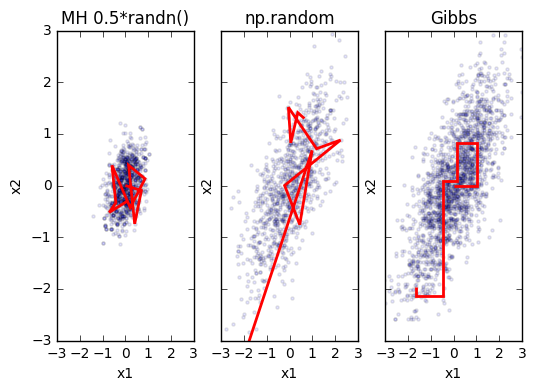

In [66]:
fig,ax = plt.subplots(1,3,sharey=True)
ax[0].set_title('MH %2.1f*randn()' % sig)
ax[1].set_title('np.random')
ax[2].set_title('Gibbs')

plot_samples(ax[0],msamples)
plot_samples(ax[1],npsamples)
plot_samples(ax[2],gsamples)

In [69]:
def corr(trace):
    """ calculate the autocorrelation of a trace of scalar data
    pre:  trace should be a 1D iterable array of floating point numbers
    post: return the autocorrelation of this trace of scalars
    """

    mu     = np.mean(trace)
    stddev = np.std(trace,ddof=1)

    correlation_time = 0.
    for k in range(1,len(trace)):
        # calculate auto_correlation
        auto_correlation = 0.0
        num = len(trace)-k
        for i in range(num):
            auto_correlation += (trace[i]-mu)*(trace[i+k]-mu)
        # end for i
        auto_correlation *= 1.0/(num*stddev**2)
        if auto_correlation > 0:
            correlation_time += auto_correlation
        else:
            break
        # end if
    # end for k

    correlation_time = 1.0 + 2.0*correlation_time
    return correlation_time

# end def corr

In [71]:
nsample = 10000
nrho = 20
rhos = np.linspace(0,0.95,nrho)
corrs= np.zeros(nrho)
for irho in range(nrho):
    rho = rhos[irho]
    my_samples = gibbs_bivariate_std_normal(rho,nsample)
    myx,myy = my_samples.T
    corrs[irho] = corr(myx[::2])
# end for

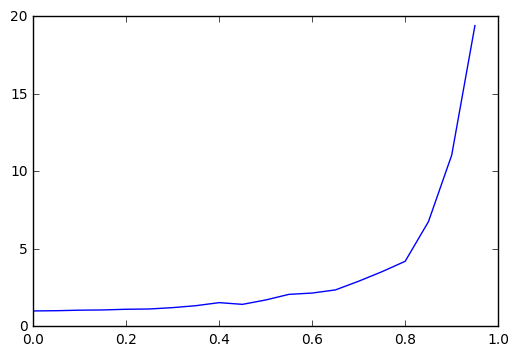

In [72]:
plt.plot(rhos,corrs)